In [118]:
import os
import cv2
import json
import numpy as np

In [119]:
def get_dataset_paths(data_path):
    '''
    Get the file paths for the real and synthetic data
    :param data_path: The path to the data
    :return: real_data_files: The file paths for the real data
             synthetic_data_files: The file paths for the synthetic data
    '''
    # Load all the image file paths for real and synthetic data
    synthetic_data = os.path.join(data_path, "ThisPersonDoesNotExist")
    synthetic_data_files = []
    for dir in os.listdir(synthetic_data):
        synthetic_data_files.extend([os.path.join(synthetic_data, dir, f) for f in os.listdir(os.path.join(synthetic_data, dir))])

    # Load the json subset of the real data
    with open("real_faces_subset.json") as f:
        real_data_json = json.load(f)
    
    # Build the real data file paths
    real_data_files = []
    for file_entry in real_data_json['files']:
        real_data_files.append(os.path.join(data_path, file_entry))
    
    return real_data_files, synthetic_data_files


def load_and_resize_images(file_paths, size=(64, 64)):
    '''
    Load the images from the file paths
    :param file_paths: The file paths to the images
    :return: The images in numpy array format
    '''
    images = []
    for file_path in file_paths:
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, size)
        images.append(image)
    return np.array(images)


def shuffle_data(X, y):
    '''
    Shuffles the data
    :param X: The data
    :param y: The labels
    :return: The shuffled data and labels
    '''
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    return X[indices], y[indices]


def split_data(data):
    '''
    Split the data into training, validation and test sets (60 - 20 - 20 split)
    :param data: The data to split
    :return: The training, validation and test sets
    '''
    return np.split(data, [int(0.6 * len(data)), int(0.8 * len(data))])


def augment_data(X_images, augmentations, n_augmentations=5):
    '''
    Augments the data by selecting from a random augmentation from a set of augmentations to apply to a random image
    This is repeated n_augmentations times
    :param X_images: The images in numpy array format
    :param augmentations: The set of augmentations to apply
    :param n_augmentations: The number of augmentations to apply
    :return: X_images: Dataset with augmented images in numpy array format
    '''
    if n_augmentations == 0:
        return X_images

    augmented_images = []
    for i in range(n_augmentations):
        random_index = np.random.randint(0, len(X_images))
        random_augmentation = np.random.choice(augmentations)
        augmented_images.append(random_augmentation(X_images[random_index]))
    
    return np.concatenate((X_images, augmented_images), axis=0)


def add_random_noise(image):
    '''
    Adds random noise to the image
    :param image: The image to add noise to
    :return: The noisy image
    '''
    # Normalize the image to [0, 1]
    normalized_image = image / 255
    # Add Gaussian noise
    noise = np.random.normal(0, 0.05, normalized_image.shape)
    noisy_image = normalized_image + noise
    # Clip the noisy image to [0, 1]
    noisy_image_clipped = np.clip(noisy_image, 0, 1)
    # Convert the noisy image back to [0, 255]
    return (noisy_image_clipped * 255).astype(np.uint8)


def jitter_image(image):
    '''
    Randomly shifts the image either up, down, left or right by a random small amount of pixels
    :param image: The image to jitter
    :return: The jittered image
    '''
    # Choose a random direction to shift the image
    direction = np.random.choice(["up", "down", "left", "right"])
    # Choose a random amount to shift the image
    amount = np.random.randint(1, 10)
    # Sample a random pixel on the direction edge for the color to use
    # This does not look as good as it sounds
    if direction == "up":
        color = image[0, np.random.randint(0, image.shape[1])]
    elif direction == "down":
        color = image[-1, np.random.randint(0, image.shape[1])]
    elif direction == "left":
        color = image[np.random.randint(0, image.shape[0]), 0]
    else:
        color = image[np.random.randint(0, image.shape[0]), -1]

    # Shift the image and replace the empty space with border color pixels
    if direction == "up":
        jittered_image = np.vstack((np.full((amount, image.shape[1], 3), color), image[:-amount]))
    elif direction == "down":
        jittered_image = np.vstack((image[amount:], np.full((amount, image.shape[1], 3), color)))
    elif direction == "left":
        jittered_image = np.hstack((np.full((image.shape[0], amount, 3), color), image[:, :-amount]))
    else:
        jittered_image = np.hstack((image[:, amount:], np.full((image.shape[0], amount, 3), color)))
    return jittered_image

In [120]:
real_files, synthetic_files = get_dataset_paths("dataset")
real_images = load_and_resize_images(real_files)
synthetic_images = load_and_resize_images(synthetic_files)

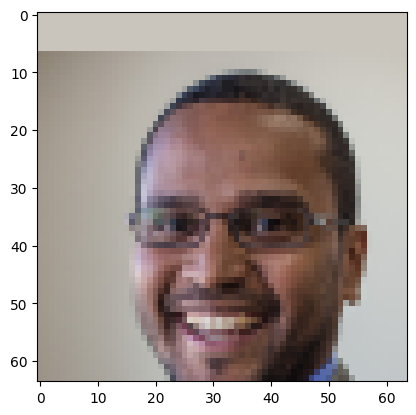

In [121]:
from matplotlib import pyplot as plt
img = real_images[0]
augmentations = [   lambda image: cv2.flip(image, 1),
                    lambda image: add_random_noise(image),
                    lambda image: jitter_image(image)]
img = augmentations[2](img)
plt.imshow(img)
# Not using jitter for now
augmentations = [lambda image: cv2.flip(image, 1),
                 lambda image: add_random_noise(image)]

In [122]:
target_dataset_size = 10000
real_images = augment_data(real_images, augmentations, target_dataset_size - len(real_images))
synthetic_images = augment_data(synthetic_images, augmentations, target_dataset_size - len(synthetic_images))
print(len(real_images))
print(len(synthetic_images))

10000
10000


In [123]:
# Combined Data with associated labels
X = np.concatenate((real_images, synthetic_images))
y = np.concatenate((np.ones(len(real_images)), np.zeros(len(synthetic_images))))

In [124]:
X, y = shuffle_data(X, y)

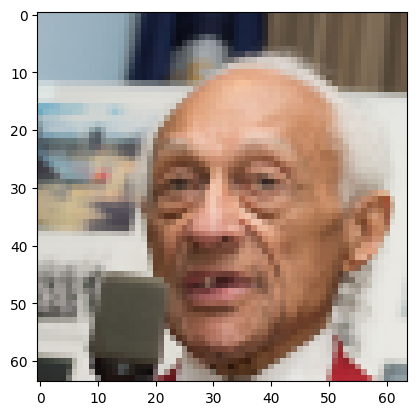

In [125]:
img = X[0]
plt.imshow(img)

In [126]:
X_train, X_val, X_test = split_data(X)
y_train, y_val, y_test = split_data(y)

In [127]:
import torch
torch.manual_seed(0)

In [128]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.conv2 = torch.nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv3 = torch.nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.fc = torch.nn.Linear(256 * 8 * 8, 1)
        self.dropout = torch.nn.Dropout(0.5)
        self.leaky_relu = torch.nn.LeakyReLU(0.2)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, x):
        x = self.leaky_relu(self.conv1(x))
        x = self.leaky_relu(self.conv2(x))
        x = self.leaky_relu(self.conv3(x))
        x = x.reshape(-1, 256 * 8 * 8)
        x = self.dropout(x)
        x = self.fc(x)
        return self.sigmoid(x)

In [129]:
batch_size = 64
learning_rate = 0.0002
weight_decay = 1e-5
epochs = 20
gan_latent_dim = 100
num_gan_images_per_batch = 8

In [130]:
from torchmetrics import Precision, Recall

In [131]:
def calculate_metrics(y_pred, y_true):
    precision = Precision(task="binary")
    recall = Recall(task="binary")
    precision = precision(y_pred, y_true)
    recall = recall(y_pred, y_true)
    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)
    return precision, recall, f1

In [132]:
def train_discriminator(X_train, y_train, X_val, y_val, batch_size, n_epochs, learning_rate, weight_decay):
    '''
    Train the discriminator
    :param X_train: The training data
    :param y_train: The training labels
    :param X_val: The validation data
    :param y_val: The validation labels
    :param batch_size: The batch size
    :param n_epochs: The number of epochs
    :return: The trained model
    '''
    discriminator = Discriminator()
    cross_entropy = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, weight_decay=weight_decay)

    metrics = {}
    metrics['train_loss'] = []
    metrics['val_loss'] = []
    metrics['train_precision'] = []
    metrics['val_precision'] = []
    metrics['train_recall'] = []
    metrics['val_recall'] = []
    metrics['train_f1'] = []
    metrics['val_f1'] = []

    for epoch in range(n_epochs):
        discriminator.train()
        num_batches = 0
        avg_loss = 0
        avg_percision = 0
        avg_recall = 0
        avg_f1 = 0

        X_train, y_train = shuffle_data(X_train, y_train)
        for i in range(0, len(X_train), batch_size):
            # Format Batch and Normalize Image
            x_batch = torch.tensor(X_train[i:i + batch_size], dtype=torch.float32)
            x_batch = x_batch.permute(0, 3, 1, 2)
            x_batch = x_batch / 255
            # Add an extra dimension for the y label
            y_batch = torch.tensor(y_train[i:i + batch_size], dtype=torch.float32).view(-1, 1)

            # Forward pass
            y_pred = discriminator(x_batch)
            loss = cross_entropy(y_pred, y_batch)
            avg_loss += loss.item()

            percision, recall, f1 = calculate_metrics(y_pred, y_batch)
            avg_percision += percision
            avg_recall += recall
            avg_f1 += f1

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            num_batches += 1

        avg_loss /= num_batches
        avg_percision /= num_batches
        avg_recall /= num_batches
        avg_f1 /= num_batches

        # Validation
        discriminator.eval()
        num_batches = 0
        val_loss = 0
        val_percision = 0
        val_recall = 0
        val_f1 = 0
        # Shuffle the validation data
        X_val, y_val = shuffle_data(X_val, y_val)
        for i in range(0, len(X_val), batch_size):
            # Format Batch and Normalize Image
            x_batch = torch.tensor(X_val[i:i + batch_size], dtype=torch.float32)
            x_batch = x_batch.permute(0, 3, 1, 2)
            x_batch = x_batch / 255
            # Add an extra dimension for the y label
            y_batch = torch.tensor(y_val[i:i + batch_size], dtype=torch.float32).view(-1, 1)
            # Forward pass
            y_pred = discriminator(x_batch)
            loss = cross_entropy(y_pred, y_batch)
            val_loss += loss.item()

            percision, recall, f1 = calculate_metrics(y_pred, y_batch)
            val_percision += percision
            val_recall += recall
            val_f1 += f1

            num_batches += 1

        val_loss /= num_batches
        val_percision /= num_batches
        val_recall /= num_batches
        val_f1 /= num_batches

        metrics['train_loss'].append(avg_loss)
        metrics['val_loss'].append(val_loss)
        metrics['train_precision'].append(avg_percision)
        metrics['val_precision'].append(val_percision)
        metrics['train_recall'].append(avg_recall)
        metrics['val_recall'].append(val_recall)
        metrics['train_f1'].append(avg_f1)
        metrics['val_f1'].append(val_f1)

        print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {avg_loss:.4f}, Percision: {avg_percision:.4f}, Recall: {avg_recall:.4f}, F1: {avg_f1:.4f}")
        print(f"Validation, Loss: {val_loss:.4f}, Percision: {val_percision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")
    
    return discriminator, metrics

In [133]:
discriminator_no_gan, metrics = train_discriminator(X_train, y_train, X_val, y_val, batch_size, epochs, learning_rate, weight_decay)

Epoch 1/20, Loss: 0.6466, Percision: 0.6196, Recall: 0.5814, F1: 0.5629
Validation, Loss: 0.5946, Percision: 0.7147, Recall: 0.6003, F1: 0.6479
Epoch 2/20, Loss: 0.5449, Percision: 0.7287, Recall: 0.7162, F1: 0.7144
Validation, Loss: 0.4931, Percision: 0.7674, Recall: 0.7337, F1: 0.7477
Epoch 3/20, Loss: 0.4728, Percision: 0.7826, Recall: 0.7739, F1: 0.7726
Validation, Loss: 0.4440, Percision: 0.7616, Recall: 0.8815, F1: 0.8145
Epoch 4/20, Loss: 0.4235, Percision: 0.8075, Recall: 0.8082, F1: 0.8020
Validation, Loss: 0.3910, Percision: 0.8179, Recall: 0.8347, F1: 0.8239
Epoch 5/20, Loss: 0.3775, Percision: 0.8308, Recall: 0.8349, F1: 0.8283
Validation, Loss: 0.3496, Percision: 0.8351, Recall: 0.8760, F1: 0.8534
Epoch 6/20, Loss: 0.3332, Percision: 0.8528, Recall: 0.8624, F1: 0.8536
Validation, Loss: 0.3215, Percision: 0.8190, Recall: 0.9477, F1: 0.8767
Epoch 7/20, Loss: 0.2985, Percision: 0.8691, Recall: 0.8810, F1: 0.8714
Validation, Loss: 0.2827, Percision: 0.9090, Recall: 0.8350, F1:

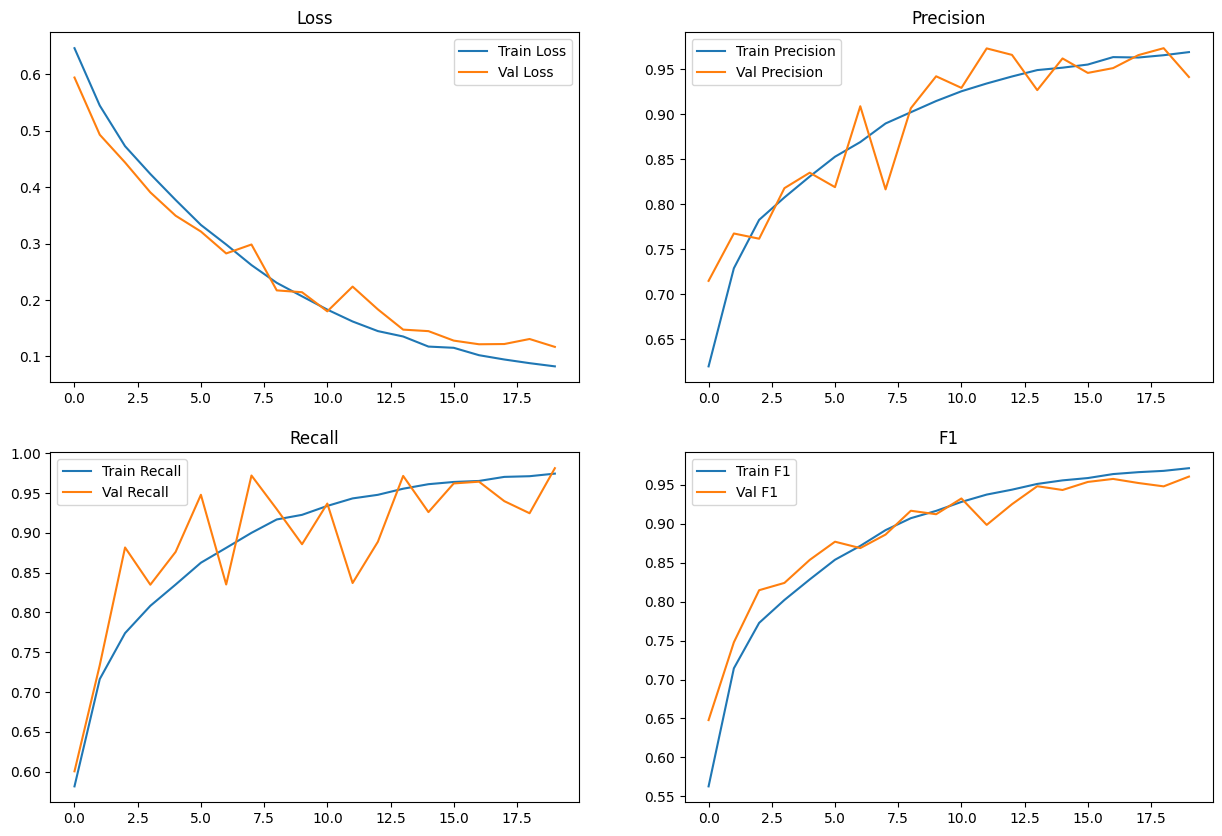

In [134]:
from matplotlib import pyplot as plt

def plot_metrics(metrics):
    '''
    Plots the metrics
    :param metrics: The metrics to plot
    '''
    if "train_gan_loss" in metrics.keys():
        fig, ax = plt.subplots(2, 3, figsize=(15, 10))
        ax[0, 0].plot(metrics['train_gan_loss'], label='Train GAN Loss')
        ax[0, 0].set_title('GAN Loss')
        ax[0, 0].legend()

        ax[0, 1].plot(metrics['train_loss'], label='Train Discriminator Loss')
        ax[0, 1].plot(metrics['val_loss'], label='Val Discriminator Loss')
        ax[0, 1].set_title('Discriminator Loss')
        ax[0, 1].legend()

        ax[0, 2].plot(metrics['train_precision'], label='Train Precision')
        ax[0, 2].plot(metrics['val_precision'], label='Val Precision')
        ax[0, 2].set_title('Precision')
        ax[0, 2].legend()

        ax[1, 0].plot(metrics['train_recall'], label='Train Recall')
        ax[1, 0].plot(metrics['val_recall'], label='Val Recall')
        ax[1, 0].set_title('Recall')
        ax[1, 0].legend()

        ax[1, 1].plot(metrics['train_f1'], label='Train F1')
        ax[1, 1].plot(metrics['val_f1'], label='Val F1')
        ax[1, 1].set_title('F1')
        ax[1, 1].legend()

        plt.show()

    else:
        fig, ax = plt.subplots(2, 2, figsize=(15, 10))
        ax[0, 0].plot(metrics['train_loss'], label='Train Loss')
        ax[0, 0].plot(metrics['val_loss'], label='Val Loss')
        ax[0, 0].set_title('Loss')
        ax[0, 0].legend()

        ax[0, 1].plot(metrics['train_precision'], label='Train Precision')
        ax[0, 1].plot(metrics['val_precision'], label='Val Precision')
        ax[0, 1].set_title('Precision')
        ax[0, 1].legend()

        ax[1, 0].plot(metrics['train_recall'], label='Train Recall')
        ax[1, 0].plot(metrics['val_recall'], label='Val Recall')
        ax[1, 0].set_title('Recall')
        ax[1, 0].legend()

        ax[1, 1].plot(metrics['train_f1'], label='Train F1')
        ax[1, 1].plot(metrics['val_f1'], label='Val F1')
        ax[1, 1].set_title('F1')
        ax[1, 1].legend()

        plt.show()

plot_metrics(metrics)

In [147]:
class Generator(torch.nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.fc = torch.nn.Linear(latent_dim, 256 * 8 * 8)
        self.deconv1 = torch.nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.deconv2 = torch.nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv3 = torch.nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)
        self.leaky_relu = torch.nn.LeakyReLU(0.2)
        self.tanh = torch.nn.Tanh()
    
    def forward(self, x):
        x = self.fc(x)
        x = x.reshape(-1, 256, 8, 8)
        x = self.leaky_relu(self.deconv1(x))
        x = self.leaky_relu(self.deconv2(x))
        x = self.tanh(self.deconv3(x))
        return x

In [180]:
def train_discriminator_with_gan(X_train, y_train, X_val, y_val, batch_size, n_epochs, learning_rate, weight_decay, latent_dim, num_gan_images):
    '''
    Train the discriminator with GAN
    :param X_train: The training data
    :param y_train: The training labels
    :param X_val: The validation data
    :param y_val: The validation labels
    :param batch_size: The batch size
    :param n_epochs: The number of epochs
    :param latent_dim: The latent dimension
    :return: The trained model
    '''
    discriminator = Discriminator()
    generator = Generator(latent_dim)
    cross_entropy_disc = torch.nn.BCELoss()
    cross_entropy_gen = torch.nn.BCELoss()
    optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, weight_decay=weight_decay)
    optimizer_generator = torch.optim.Adam(generator.parameters(), lr=learning_rate, weight_decay=weight_decay)

    metrics = {}
    metrics['train_loss'] = []
    metrics['val_loss'] = []
    metrics['train_precision'] = []
    metrics['val_precision'] = []
    metrics['train_recall'] = []
    metrics['val_recall'] = []
    metrics['train_f1'] = []
    metrics['val_f1'] = []
    metrics['train_gan_loss'] = []
    
    prev_gan_loss = None
    for epoch in range(n_epochs):
        discriminator.train()
        generator.train()
        num_batches = 0
        avg_loss = 0
        avg_percision = 0
        avg_recall = 0
        avg_f1 = 0
        avg_gan_loss = 0

        X_train, y_train = shuffle_data(X_train, y_train)
        for i in range(0, len(X_train), batch_size):
            # Format Batch and Normalize Image
            x_batch = torch.tensor(X_train[i:i + batch_size], dtype=torch.float32)
            x_batch = x_batch.permute(0, 3, 1, 2)
            x_batch = x_batch / 255
            # Add GAN images to x_batch and shuffle (25% of the batch)
            if prev_gan_loss is None or prev_gan_loss < 3.0:
                latent_vectors = torch.randn(num_gan_images, latent_dim)
                gan_images = generator(latent_vectors)
                x_batch = torch.cat((x_batch, gan_images), 0)
                # Add an extra dimension for the y label
                y_batch = torch.tensor(y_train[i:i + batch_size], dtype=torch.float32).view(-1, 1)
                y_batch = torch.cat((y_batch, torch.zeros(num_gan_images, 1)), 0)
            else:
                y_batch = torch.tensor(y_train[i:i + batch_size], dtype=torch.float32).view(-1, 1)
            # Shuffle the batch
            x_batch, y_batch = shuffle_data(x_batch, y_batch)

            # Forward pass
            y_pred = discriminator(x_batch)
            loss_disc = cross_entropy_disc(y_pred, y_batch)
            avg_loss += loss_disc.item()

            percision, recall, f1 = calculate_metrics(y_pred, y_batch)
            avg_percision += percision
            avg_recall += recall
            avg_f1 += f1

            # Backward pass
            optimizer_discriminator.zero_grad()
            loss_disc.backward()
            optimizer_discriminator.step()

            # Train the generator
            latent_vectors = torch.randn(num_gan_images_per_batch, latent_dim)
            gan_images = generator(latent_vectors)

            y_pred = discriminator(gan_images)
            loss_gen = cross_entropy_gen(y_pred, torch.ones(num_gan_images_per_batch, 1))
            avg_gan_loss += loss_gen.item()

            if loss_gen.item() > 3.0:
                optimizer_generator.zero_grad()
                loss_gen.backward()
                optimizer_generator.step()

            num_batches += 1

        avg_loss /= num_batches
        avg_percision /= num_batches
        avg_recall /= num_batches
        avg_f1 /= num_batches
        avg_gan_loss /= num_batches

        # Validation
        discriminator.eval()
        num_batches = 0
        val_loss = 0
        val_percision = 0
        val_recall = 0
        val_f1 = 0
        # Shuffle the validation data
        X_val, y_val = shuffle_data(X_val, y_val)
        for i in range(0, len(X_val), batch_size):
            # Format Batch and Normalize Image
            x_batch = torch.tensor(X_val[i:i + batch_size], dtype=torch.float32)
            x_batch = x_batch.permute(0, 3, 1, 2)
            x_batch = x_batch / 255
            # Add an extra dimension for the y label
            y_batch = torch.tensor(y_val[i:i + batch_size], dtype=torch.float32).view(-1, 1)
            # Forward pass
            y_pred = discriminator(x_batch)
            loss = cross_entropy_disc(y_pred, y_batch)
            val_loss += loss.item()

            percision, recall, f1 = calculate_metrics(y_pred, y_batch)
            val_percision += percision
            val_recall += recall
            val_f1 += f1

            num_batches += 1

        val_loss /= num_batches
        val_percision /= num_batches
        val_recall /= num_batches
        val_f1 /= num_batches

        metrics['train_loss'].append(avg_loss)
        metrics['val_loss'].append(val_loss)
        metrics['train_precision'].append(avg_percision)
        metrics['val_precision'].append(val_percision)
        metrics['train_recall'].append(avg_recall)
        metrics['val_recall'].append(val_recall)
        metrics['train_f1'].append(avg_f1)
        metrics['val_f1'].append(val_f1)
        metrics['train_gan_loss'].append(avg_gan_loss)

        if avg_gan_loss != 0:
            prev_gan_loss = avg_gan_loss

        print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {avg_loss:.4f}, Percision: {avg_percision:.4f}, Recall: {avg_recall:.4f}, F1: {avg_f1:.4f}")
        print(f"Validation, Loss: {val_loss:.4f}, Percision: {val_percision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")
        if avg_gan_loss != 0:
            print(f"GAN Loss: {avg_gan_loss:.4f}")
        else:
            print(f"prev_gan_loss: {prev_gan_loss:.4f}")
    return discriminator, generator, metrics

In [181]:
batch_size = 64
learning_rate = 0.001
weight_decay = 1e-5
epochs = 20
gan_latent_dim = 100
num_gan_images_per_batch = 16

In [182]:
discriminator_with_gan, generator, metrics = train_discriminator_with_gan(X_train, y_train, X_val, y_val, batch_size, epochs, learning_rate, weight_decay, gan_latent_dim, num_gan_images_per_batch)

Epoch 1/20, Loss: 0.5803, Percision: 0.5682, Recall: 0.5087, F1: 0.4866
Validation, Loss: 0.6268, Percision: 0.6170, Recall: 0.7992, F1: 0.6932
GAN Loss: 4.7907
Epoch 2/20, Loss: 0.5044, Percision: 0.7627, Recall: 0.7583, F1: 0.7493
Validation, Loss: 0.3742, Percision: 0.8472, Recall: 0.8255, F1: 0.8340
GAN Loss: 0.2568
Epoch 3/20, Loss: 0.4374, Percision: 0.7767, Recall: 0.7450, F1: 0.7404
Validation, Loss: 0.3903, Percision: 0.8101, Recall: 0.8543, F1: 0.8293
GAN Loss: 5.8892
Epoch 4/20, Loss: 0.3001, Percision: 0.8743, Recall: 0.8764, F1: 0.8674
Validation, Loss: 0.2980, Percision: 0.8010, Recall: 0.9898, F1: 0.8839
GAN Loss: 0.5104
Epoch 5/20, Loss: 0.3937, Percision: 0.8137, Recall: 0.7771, F1: 0.7802
Validation, Loss: 0.4034, Percision: 0.8633, Recall: 0.8005, F1: 0.8276
GAN Loss: 4.1071
Epoch 6/20, Loss: 0.1987, Percision: 0.9175, Recall: 0.9278, F1: 0.9190
Validation, Loss: 0.1619, Percision: 0.8962, Recall: 0.9844, F1: 0.9376
GAN Loss: 0.2473
Epoch 7/20, Loss: 0.4069, Percisio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


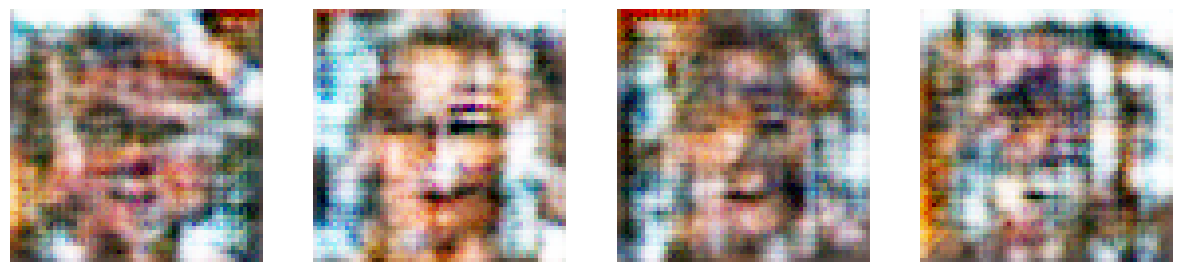

In [183]:
# sample GAN images
latent_vectors = torch.randn(4, gan_latent_dim)
gan_images = generator(latent_vectors)
gan_images = gan_images.permute(0, 2, 3, 1).detach().numpy()
fig, ax = plt.subplots(1, 4, figsize=(15, 10))
for i in range(4):
    ax[i].imshow(gan_images[i])
    ax[i].axis('off')
plt.show()

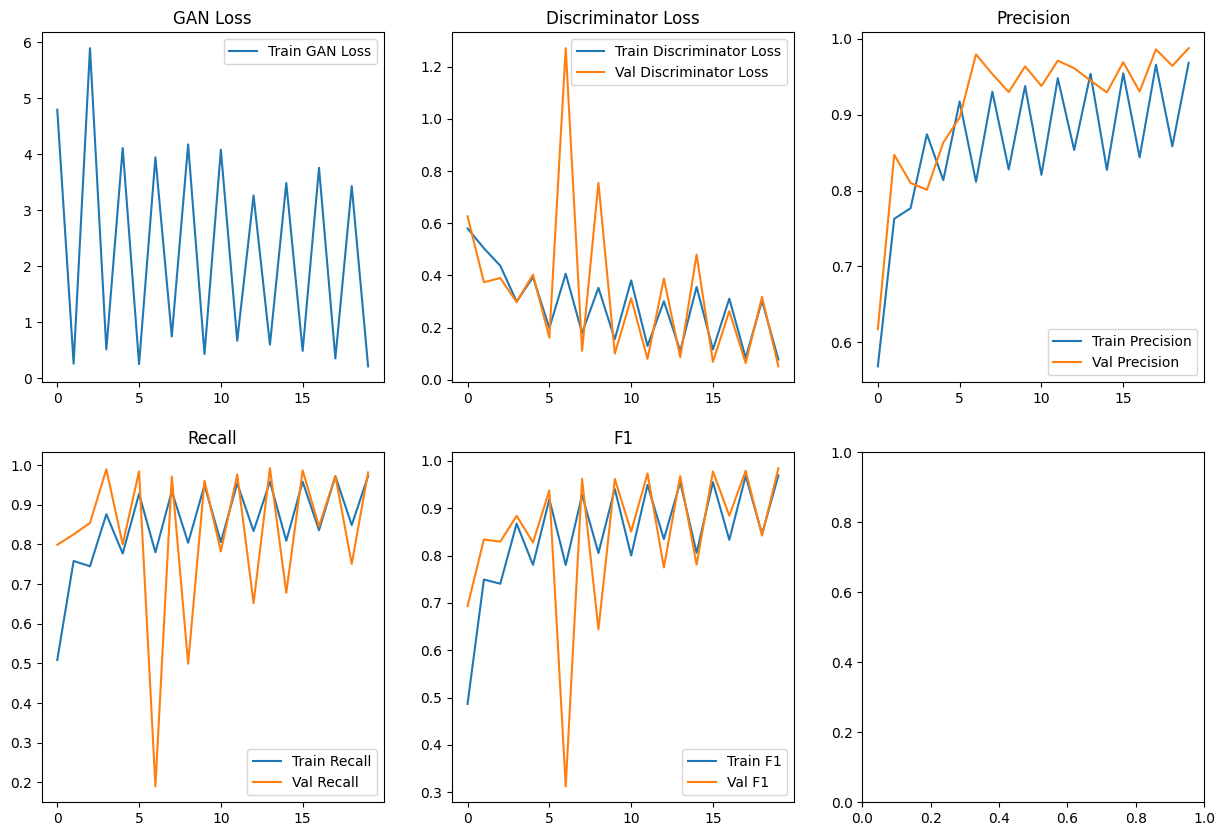

In [184]:
plot_metrics(metrics)

In [185]:
def test_discriminator(discriminator, X_test, y_test, batch_size):
    '''
    Test the discriminator
    :param discriminator: The trained discriminator
    :param X_test: The test data
    :param y_test: The test labels
    :param batch_size: The batch size
    :return: The test loss and accuracy
    '''
    discriminator.eval()
    cross_entropy = torch.nn.BCELoss()
    num_batches = 0
    test_loss = 0
    test_precision = 0
    test_recall = 0
    test_f1 = 0
    for i in range(0, len(X_test), batch_size):
        # Format Batch and Normalize Image
        x_batch = torch.tensor(X_test[i:i + batch_size], dtype=torch.float32)
        x_batch = x_batch.permute(0, 3, 1, 2)
        x_batch = x_batch / 255
        # Add an extra dimension for the y label
        y_batch = torch.tensor(y_test[i:i + batch_size], dtype=torch.float32).view(-1, 1)
        # Forward pass
        y_pred = discriminator(x_batch)
        loss = cross_entropy(y_pred, y_batch)
        test_loss += loss.item()

        precision, recall, f1 = calculate_metrics(y_pred, y_batch)
        test_precision += precision
        test_recall += recall
        test_f1 += f1

        num_batches += 1

    test_loss /= num_batches
    test_precision /= num_batches
    test_recall /= num_batches
    test_f1 /= num_batches

    return test_loss, test_precision, test_recall, test_f1

In [186]:
loss, precision, recall, f1 = test_discriminator(discriminator_no_gan, X_test, y_test, batch_size)
print(f"Discriminator Test Loss: {loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

Discriminator Test Loss: 3.4188, Precision: 0.7391, Recall: 0.7850, F1: 0.7590


In [187]:
loss, precision, recall, f1 = test_discriminator(discriminator_with_gan, X_test, y_test, batch_size)
print(f"Discriminator with GAN Test Loss: {loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

Discriminator with GAN Test Loss: 2.7722, Precision: 0.7738, Recall: 0.7808, F1: 0.7750


In [188]:
# Augment X_test with GAN images
num_gan_images = 1000
extra_gan_images = []
latent_vectors = torch.randn(num_gan_images, gan_latent_dim)
for i in range(0, num_gan_images, batch_size):
    gan_images = generator(latent_vectors[i:i + batch_size])
    gan_images = gan_images.permute(0, 2, 3, 1).detach().numpy()
    extra_gan_images.extend(gan_images)
X_test = np.concatenate((X_test, extra_gan_images))
y_test = np.concatenate((y_test, np.zeros(num_gan_images)))

In [189]:
loss, precision, recall, f1 = test_discriminator(discriminator_no_gan, X_test, y_test, batch_size)
print(f"Discriminator w/ GAN images Test Loss: {loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

Discriminator w/ GAN images Test Loss: 5.4172, Precision: 0.6211, Recall: 0.6597, F1: 0.6379


In [190]:
loss, precision, recall, f1 = test_discriminator(discriminator_with_gan, X_test, y_test, batch_size)
print(f"Discriminator with GAN w/ GAN images Test Loss: {loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

Discriminator with GAN w/ GAN images Test Loss: 4.4125, Precision: 0.6503, Recall: 0.6562, F1: 0.6513
